In [19]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout



In [20]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Directories
train_dir = "DATASET/train"
val_dir = "DATASET/validation"
test_dir = "DATASET/test"

In [21]:
# ImageDataGenerator with rescaling

# Changes here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
)

Found 16800 images belonging to 2 classes.
Found 3600 images belonging to 2 classes.
Found 3600 images belonging to 2 classes.


In [22]:
# Build and compile the Conv2D model

# Changes here

def build_model():
    base_model = layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3))

    model = models.Sequential([
        base_model,
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 17, 17, 128)      

In [23]:
# Train the model
def train_model(model, train_generator, val_generator, class_weights):
    history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=15,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32
    )
    return history

In [24]:
def evaluate_model(model, test_generator):
    """Evaluate the model."""
    # Predict using the test generator
    test_generator.reset()
    y_pred = model.predict(test_generator)
    y_pred = np.where(y_pred > 0.5, 1, 0).flatten()

    true_labels = test_generator.classes

    report = classification_report(true_labels, y_pred)
    cm = confusion_matrix(true_labels, y_pred)

    return report, cm, true_labels, y_pred

In [25]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [26]:

# Visualize predictions
def visualize_predictions(model, test_generator):
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))

    for i, image_path in enumerate(test_generator.filepaths[:10]):
        image = Image.open(image_path)
        image = image.resize((150, 150))
        image_array = np.array(image) / 255.0
        image_array = np.expand_dims(image_array, axis=0)

        y_pred = model.predict(image_array)
        confidence = y_pred[0][0]
        predicted_label = np.where(y_pred > 0.5, 1, 0)[0][0]
        actual_label = test_generator.classes[i]

        row = i // 5
        col = i % 5

        axs[row, col].imshow(image)
        axs[row, col].set_title(f"Predicted: {predicted_label}, Actual: {actual_label}\nConfidence: {confidence:.2f}")
        axs[row, col].axis('off')

    plt.tight_layout()
    plt.show()


Epoch 1/15
525/525 [==============================] - 197s 371ms/step - loss: 0.5536 - accuracy: 0.7124 - val_loss: 0.4436 - val_accuracy: 0.8100
Epoch 2/15
525/525 [==============================] - 198s 377ms/step - loss: 0.4567 - accuracy: 0.7930 - val_loss: 0.3792 - val_accuracy: 0.8516
Epoch 3/15
525/525 [==============================] - 208s 395ms/step - loss: 0.4096 - accuracy: 0.8265 - val_loss: 0.3586 - val_accuracy: 0.8541
Epoch 4/15
525/525 [==============================] - 196s 373ms/step - loss: 0.3900 - accuracy: 0.8373 - val_loss: 0.3351 - val_accuracy: 0.8675
Epoch 5/15
525/525 [==============================] - 195s 372ms/step - loss: 0.3598 - accuracy: 0.8505 - val_loss: 0.3213 - val_accuracy: 0.8703
Epoch 6/15
525/525 [==============================] - 203s 386ms/step - loss: 0.3512 - accuracy: 0.8540 - val_loss: 0.3131 - val_accuracy: 0.8733
Epoch 7/15
525/525 [==============================] - 196s 372ms/step - loss: 0.3369 - accuracy: 0.8582 - val_loss: 0.3090 -

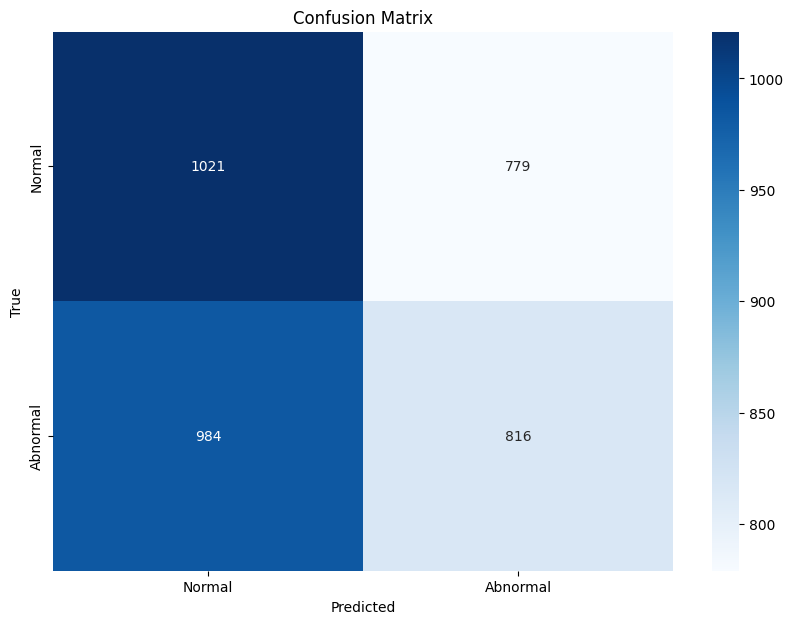

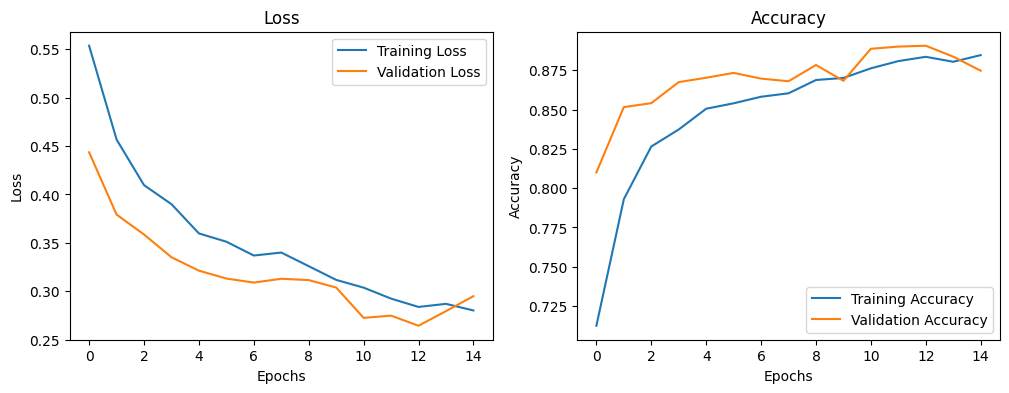

1/1 [==============================] - 0s 23ms/step


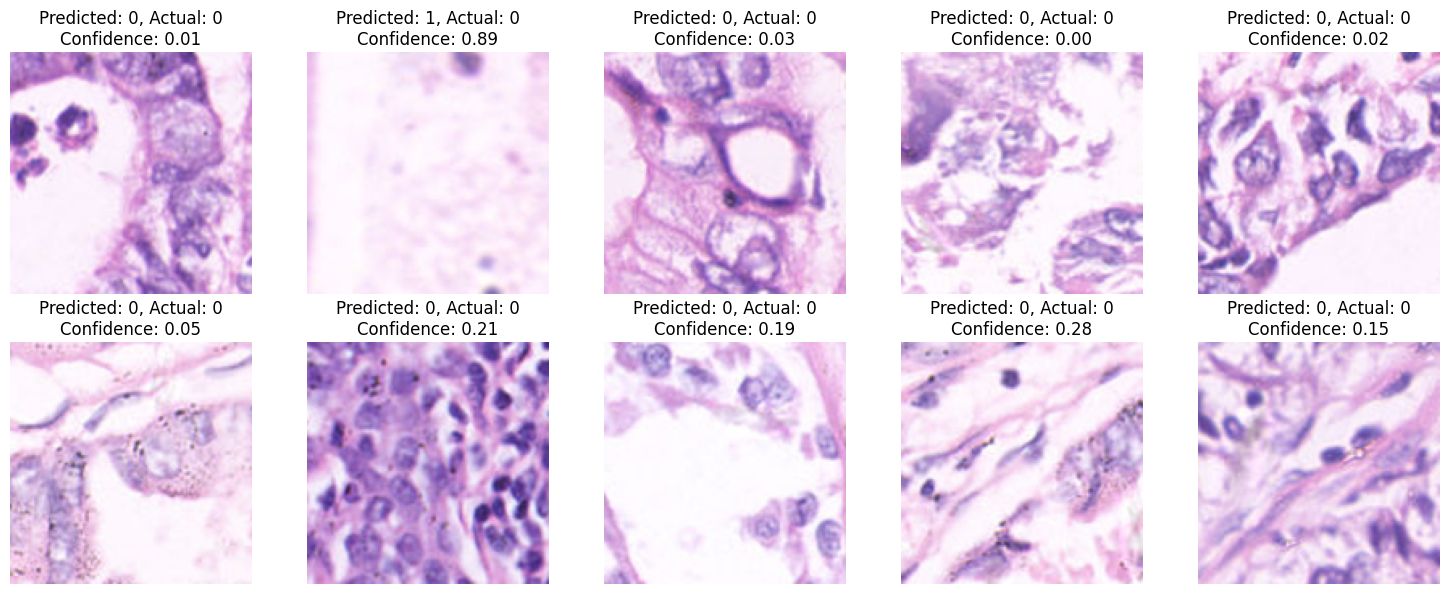

In [27]:

# Main function
def main():
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
    class_weights = dict(enumerate(class_weights))

    model = build_model()
    history = train_model(model, train_generator, val_generator, class_weights)

    report, cm, true_labels, y_pred = evaluate_model(model, test_generator)
    print("Classification Report:\n", report)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    plot_history(history)
    visualize_predictions(model, test_generator)

if __name__ == "__main__":
    main()
